# Spatial Analysis and Modeling

This notebook has been edited from the tutorial **Spatial Data Science with PyData** presented at the [GeoPython 2018](http://2018.geopython.net/) conference by

- [Levi John Wolf](https://ljwolf.org) - [University of Bristol](http://www.bristol.ac.uk/geography/levi-j-wolf/overview.html)
- [Sergio Rey](https://sergerey.org/) - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html)

In collaboration with:

- [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool
- [Wei Kang](http://spatial.ucr.edu/peopleKang.html)
- [Marynia Kolak](https://marynia.me)
- [Joris Van den Bossche](https://jorisvandenbossche.github.io/) - Ghent University 

## Spatial Autocorrelation 


In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation



# splot documentation and quick reference

Official documentation and examples for `splot`:

- ReadTheDocs: https://splot.readthedocs.io/en/latest/
- GitHub repo: https://github.com/pysal/splot
- Example notebook (Moran visualizations): https://nbviewer.org/github/pysal/splot/blob/main/notebooks/esda_morans_viz.ipynb

Quick usage examples (taken from the splot documentation):

```python
# Imports
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation

# Global Moran example
moran = Moran(y, wq)
plot_moran(moran, zstandard=True, figsize=(10,4))
fig, ax = moran_scatterplot(moran, aspect_equal=True)

# Local Moran / LISA example
moran_loc = Moran_Local(y, wq)
lisa_cluster(moran_loc, df, p=0.05, figsize=(9,9))
plot_local_autocorrelation(moran_loc, df, 'median_pri')
```

Installation notes:

```bash
pip install splot
# or
conda install -c conda-forge splot
```

Notes:
- The `splot` functions expect PySAL/esda objects (e.g., `Moran`, `Moran_Local`).
- For details on parameters and extra options (e.g., `p`, `zstandard`, `aspect_equal`, `figsize`), consult the ReadTheDocs link above.


Our data set comes from the Berlin airbnb scrape taken in April 2018. This dataframe was constructed as part of the [GeoPython 2018 workshop](https://github.com/ljwolf/geopython) by [Levi Wolf](https://ljwolf.org) and [Serge Rey](https://sergerey.org). As part of the workshop a geopandas data frame was constructed with one of the columns reporting the median listing price of units in each neighborhood in Berlin:

In [3]:
df = gpd.read_file('data/berlin-neighbourhoods/berlin-neighbourhoods.geojson')

In [4]:
df = df.to_crs(epsg=3857)

In [5]:
df.head()

,neighbourh,neighbou_1,median_pri,geometry
0,Blankenfelde/Niederschönhausen,Pankow,37.5,"MULTIPOLYGON (((1493006.88 6912074.798, 149299..."
1,Helmholtzplatz,Pankow,58.0,"MULTIPOLYGON (((1493245.549 6900059.696, 14932..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,50.0,"MULTIPOLYGON (((1481381.452 6885170.698, 14813..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,99.0,"MULTIPOLYGON (((1526159.829 6872101.044, 15261..."
4,Müggelheim,Treptow - Köpenick,25.0,"MULTIPOLYGON (((1529265.086 6874326.842, 15292..."


We have a `nan` to first deal with:

In [6]:
pd.isnull(df['median_pri']).sum()

np.int64(1)

In [7]:
df['median_pri'] = df['median_pri'].fillna(df['median_pri'].mean())

<Axes: >

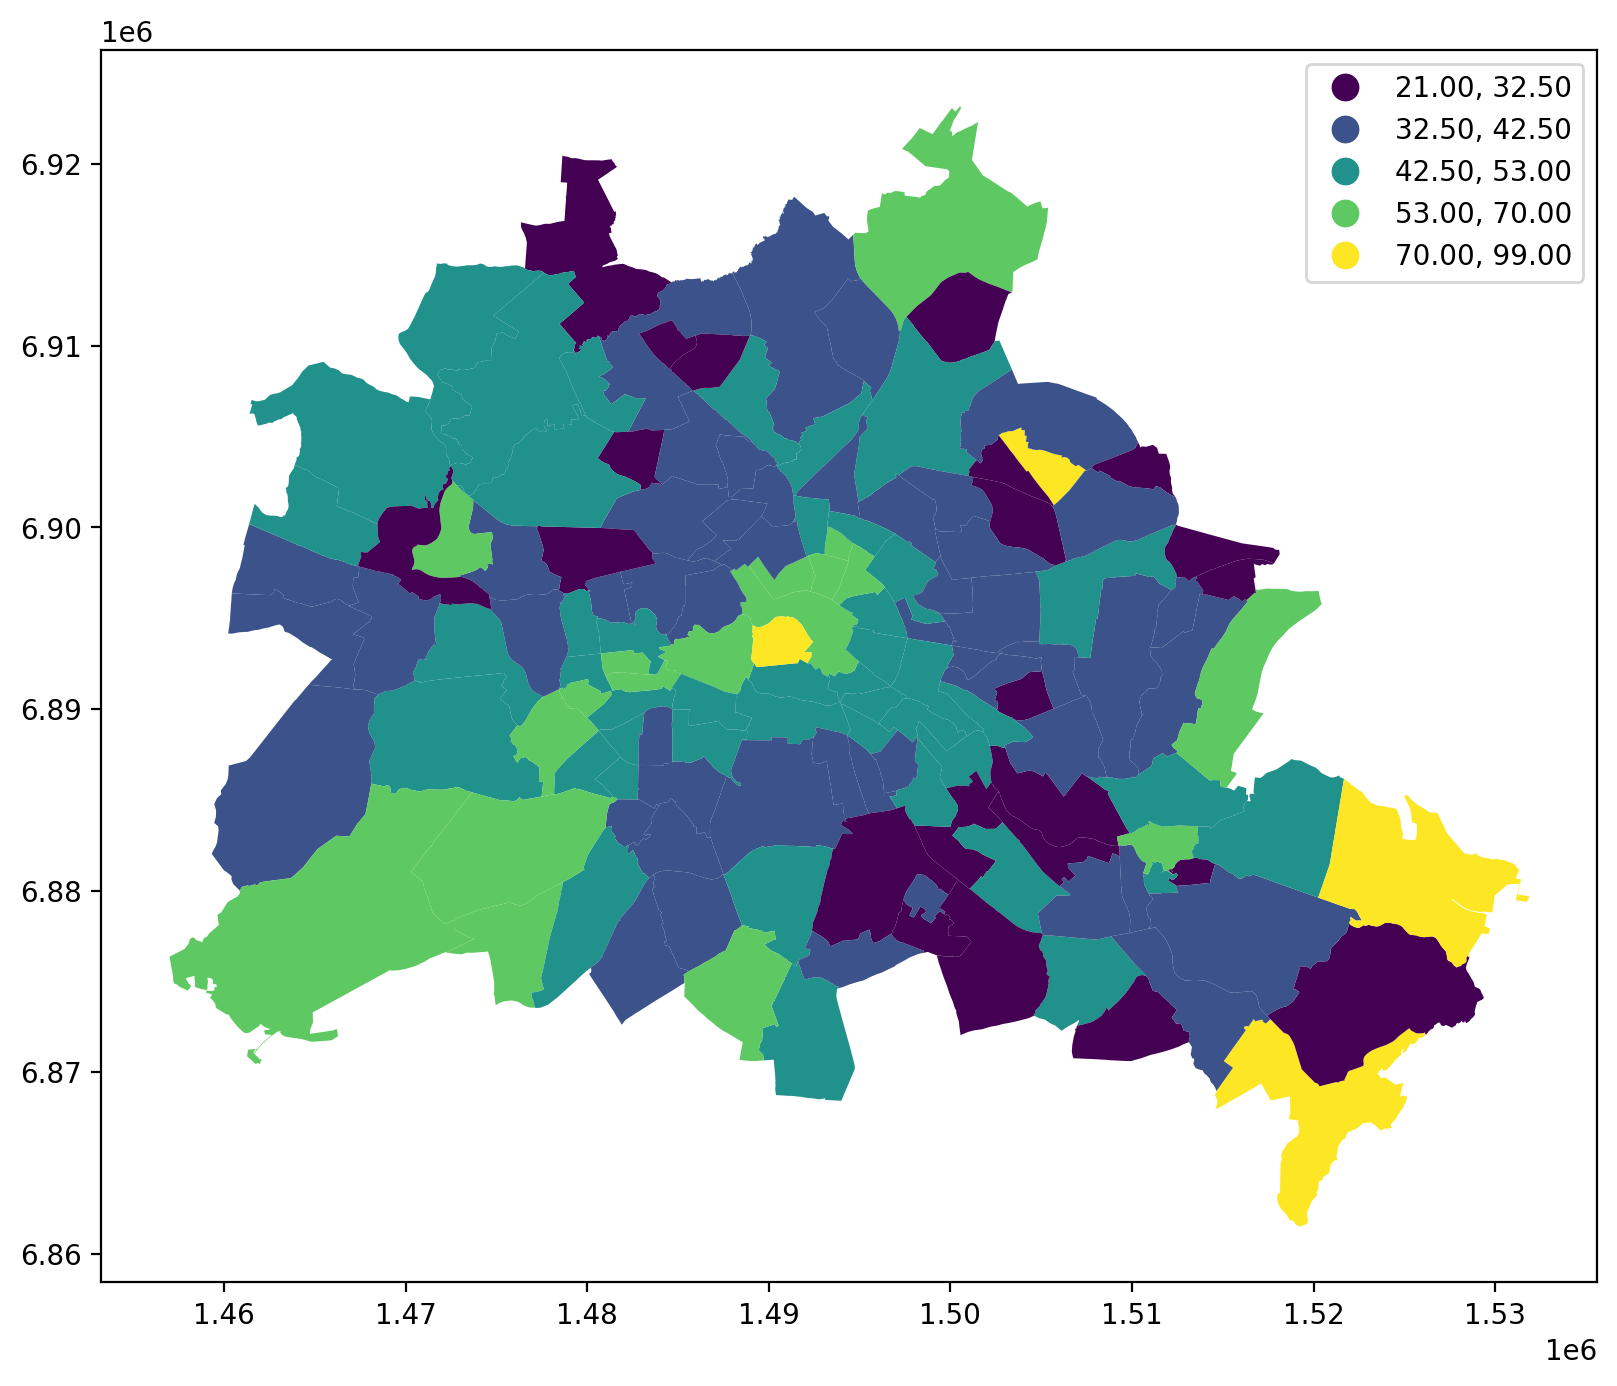

In [8]:
f, ax = plt.subplots(figsize=(12,8))
df.plot(column='median_pri', scheme='fisher_jenks', legend=True, ax=ax)

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues (lower prices) in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [9]:
import libpysal 

wq =  libpysal.weights.Queen.from_dataframe(df, use_index = True)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In [10]:
y = df['median_pri']
ylag = libpysal.weights.lag_spatial(wq, y)

In [11]:
ylag

array([45.2       , 52.625     , 45.75      , 32.5       , 63.5       ,
       42.        , 45.625     , 44.14285714, 43.33333333, 38.75      ,
       41.5       , 50.8       , 36.6875    , 54.36363636, 54.375     ,
       38.92857143, 38.125     , 50.9       , 35.6875    , 59.66666667,
       46.875     , 46.92857143, 49.58333333, 47.25      , 53.25      ,
       40.57142857, 37.66666667, 37.14285714, 40.75      , 41.5       ,
       45.9       , 35.3       , 47.9375    , 47.33333333, 40.        ,
       44.        , 58.3       , 53.16666667, 41.1459854 , 43.75      ,
       51.625     , 52.3       , 50.5       , 46.91666667, 47.        ,
       38.125     , 35.33333333, 48.83333333, 46.6       , 43.125     ,
       39.95498783, 41.33333333, 42.        , 44.43248175, 55.66666667,
       46.2       , 47.33333333, 49.84124088, 47.93248175, 42.92857143,
       43.4       , 40.78571429, 37.42857143, 32.75      , 45.57142857,
       51.25      , 44.        , 33.33333333, 33.25      , 42.  

In [12]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

In [13]:
ylagq5.yb

array([3, 4, 3, 0, 4, 2, 3, 3, 2, 1, 2, 4, 0, 4, 4, 1, 0, 4, 0, 4, 3, 3,
       4, 3, 4, 1, 0, 0, 1, 2, 3, 0, 3, 3, 1, 2, 4, 4, 2, 2, 4, 4, 4, 3,
       3, 0, 0, 4, 3, 2, 1, 2, 2, 3, 4, 3, 3, 4, 3, 2, 2, 1, 0, 0, 3, 4,
       2, 0, 0, 2, 1, 0, 2, 2, 2, 1, 2, 3, 3, 4, 0, 1, 0, 3, 2, 0, 1, 2,
       1, 1, 1, 2, 1, 2, 1, 4, 4, 4, 0, 1, 4, 4, 4, 1, 2, 2, 0, 3, 1, 4,
       4, 3, 1, 3, 2, 3, 4, 3, 1, 1, 2, 3, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0,
       0, 2, 0, 0, 0, 0])

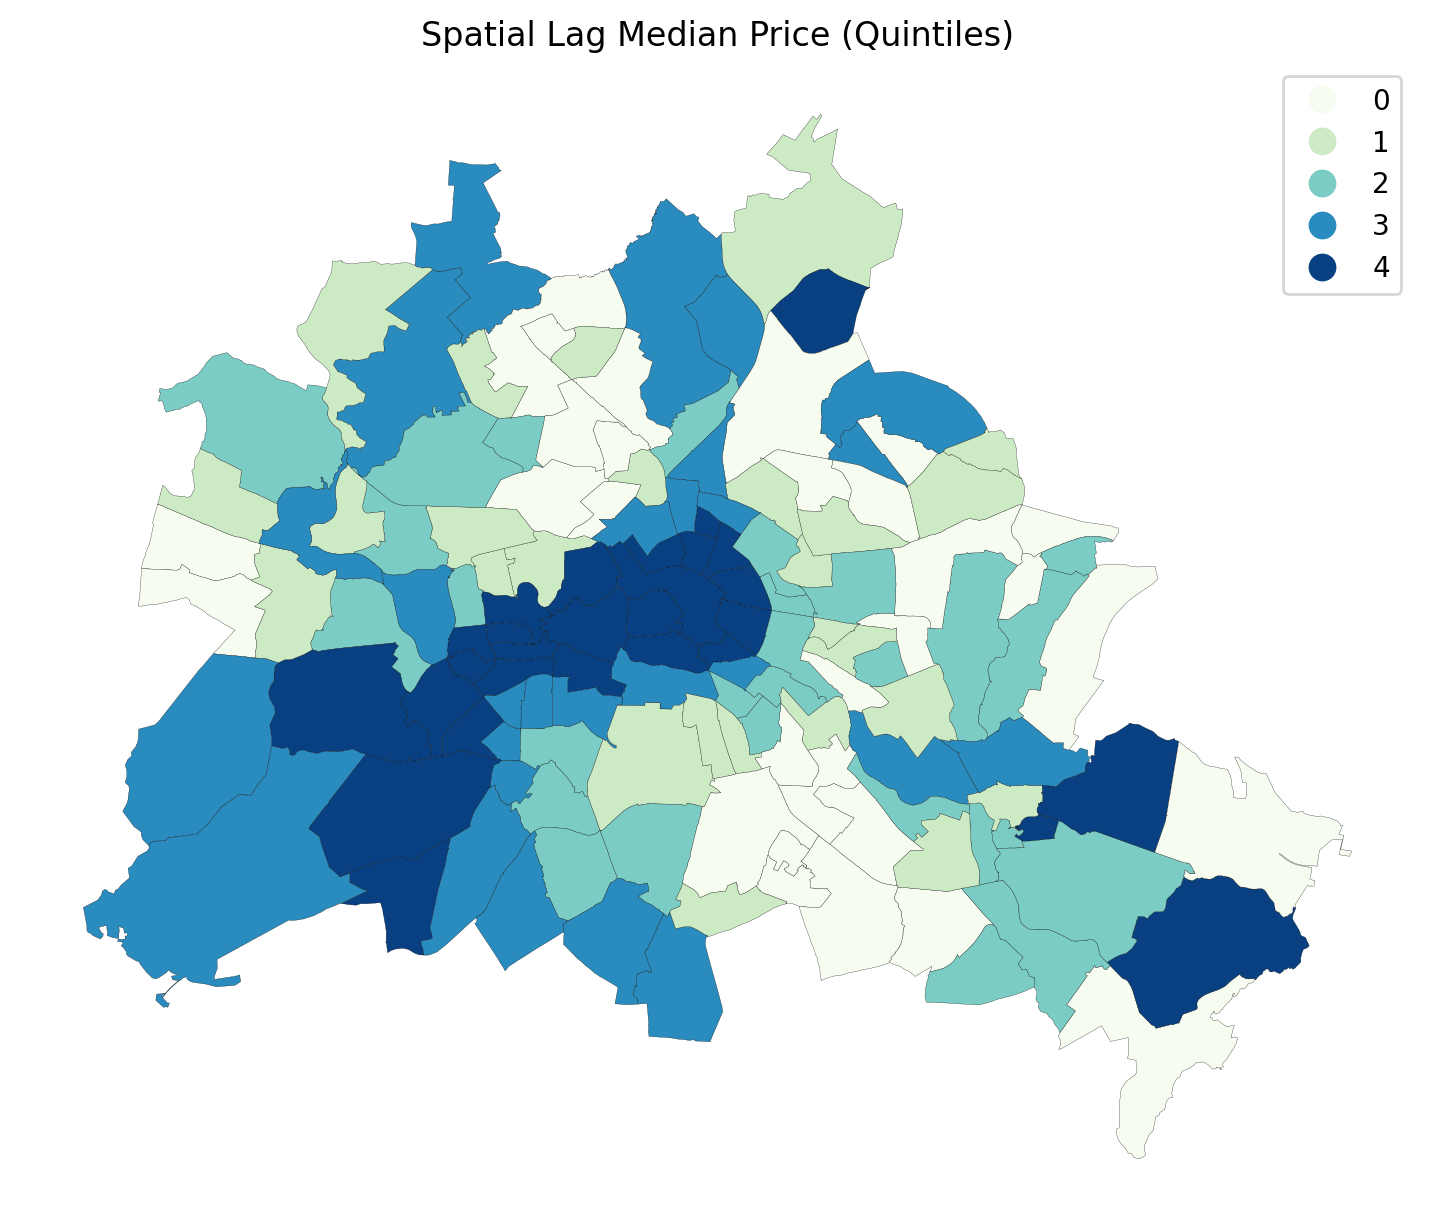

In [14]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

In [15]:
df['lag_median_pri'] = ylag

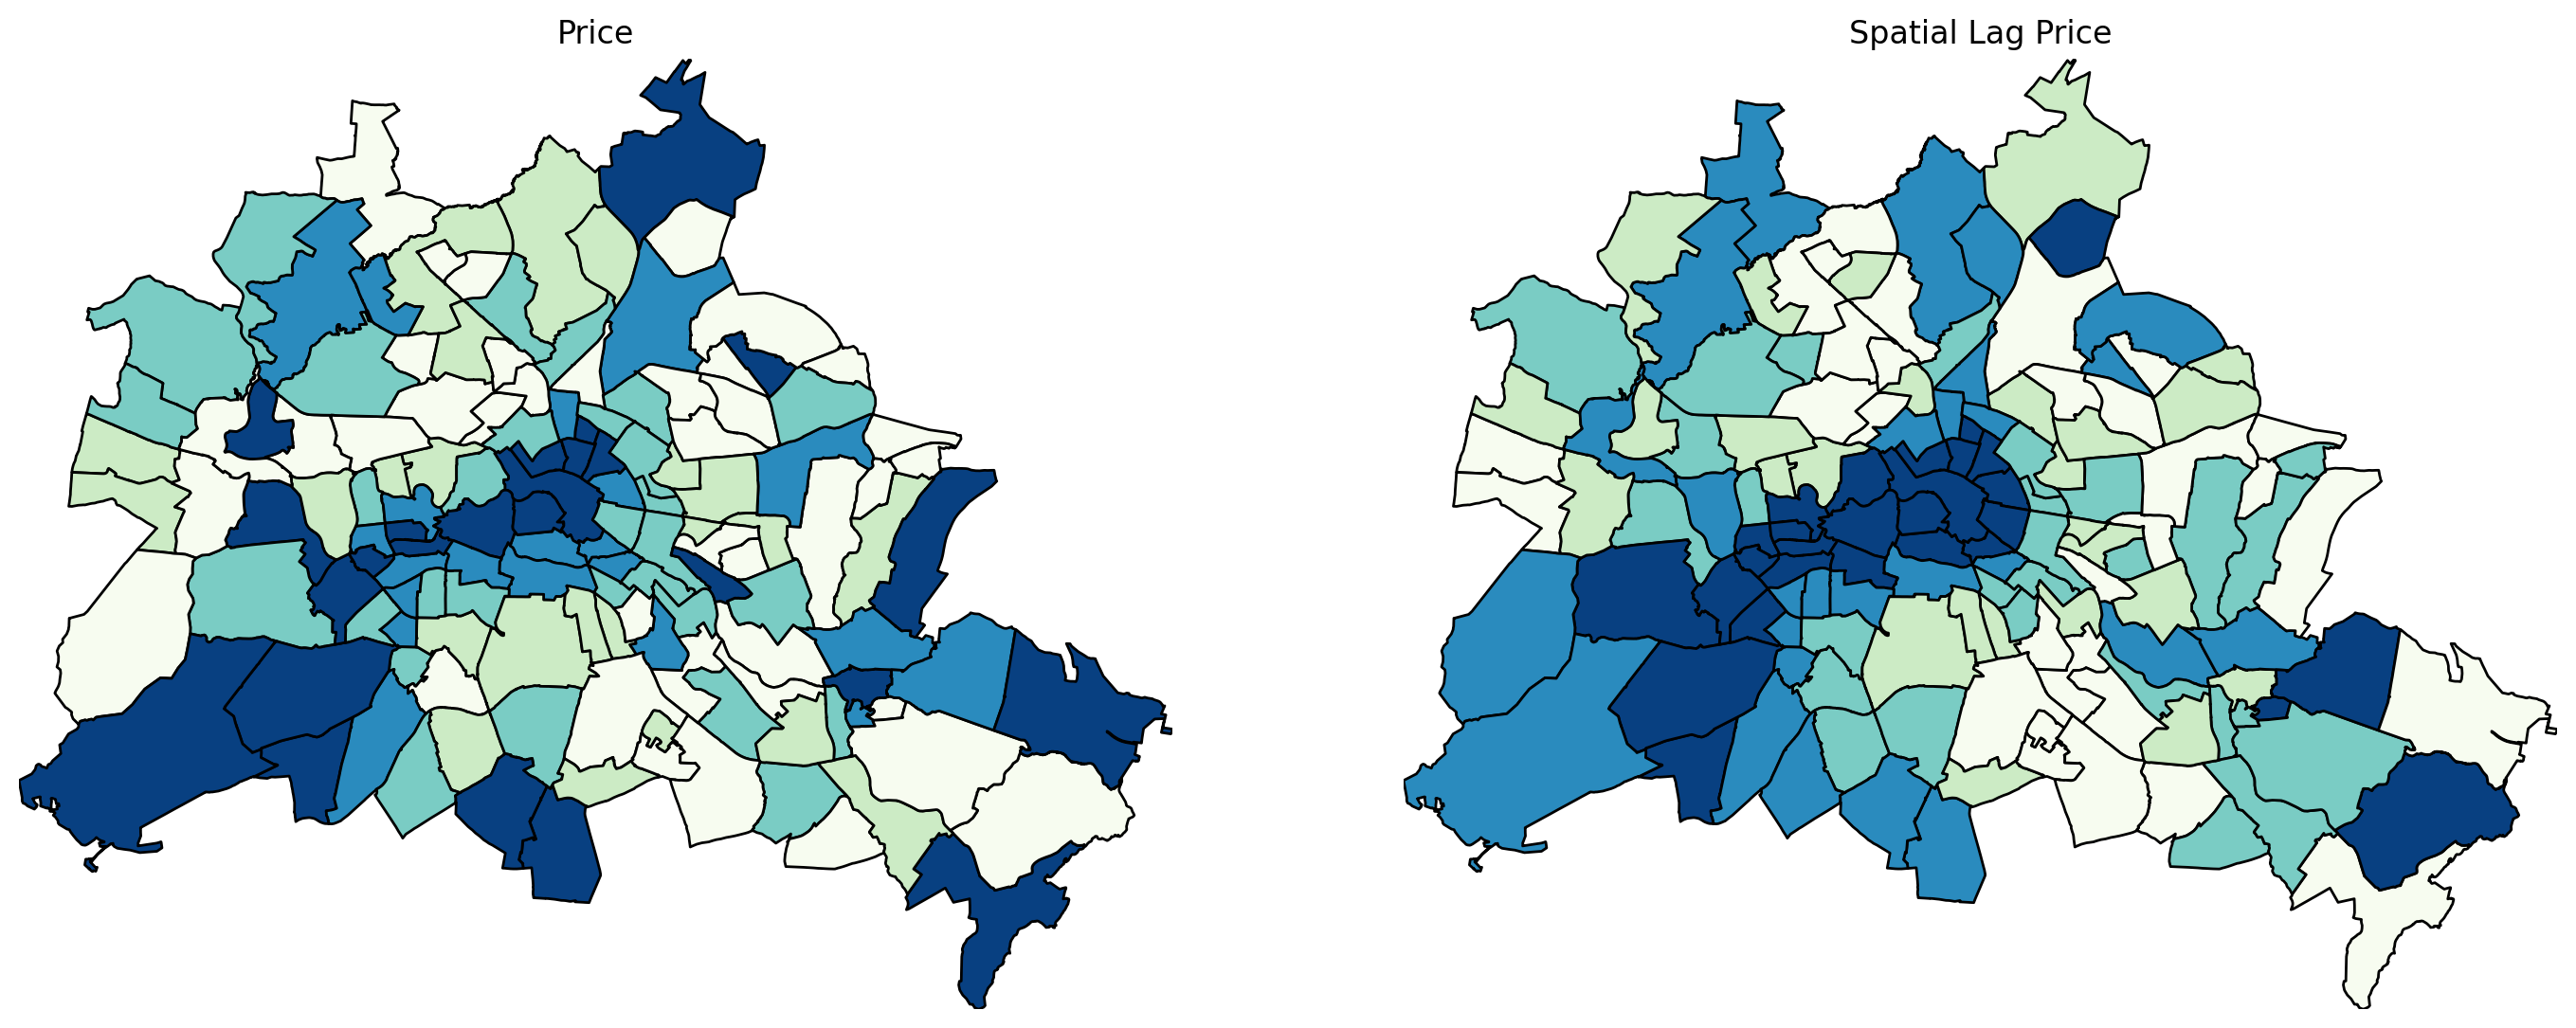

In [16]:
f,ax = plt.subplots(1,2,figsize=(2.16*8,8))

df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")


df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation

We begin with a simple case where the variable under consideration is binary.
This is useful to unpack the logic of spatial autocorrelation tests. So  even though
our attribute is a continuously valued one, we will convert it to a binary case
to illustrate the key concepts:

### Binary Case

In [17]:
y.median()

np.float64(42.0)

In [18]:
yb = y > y.median()
sum(yb)

68

We have 68 neighborhoods with list prices above the median and 70 below the
median (recall the issue with ties).

In [19]:
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

<Axes: >

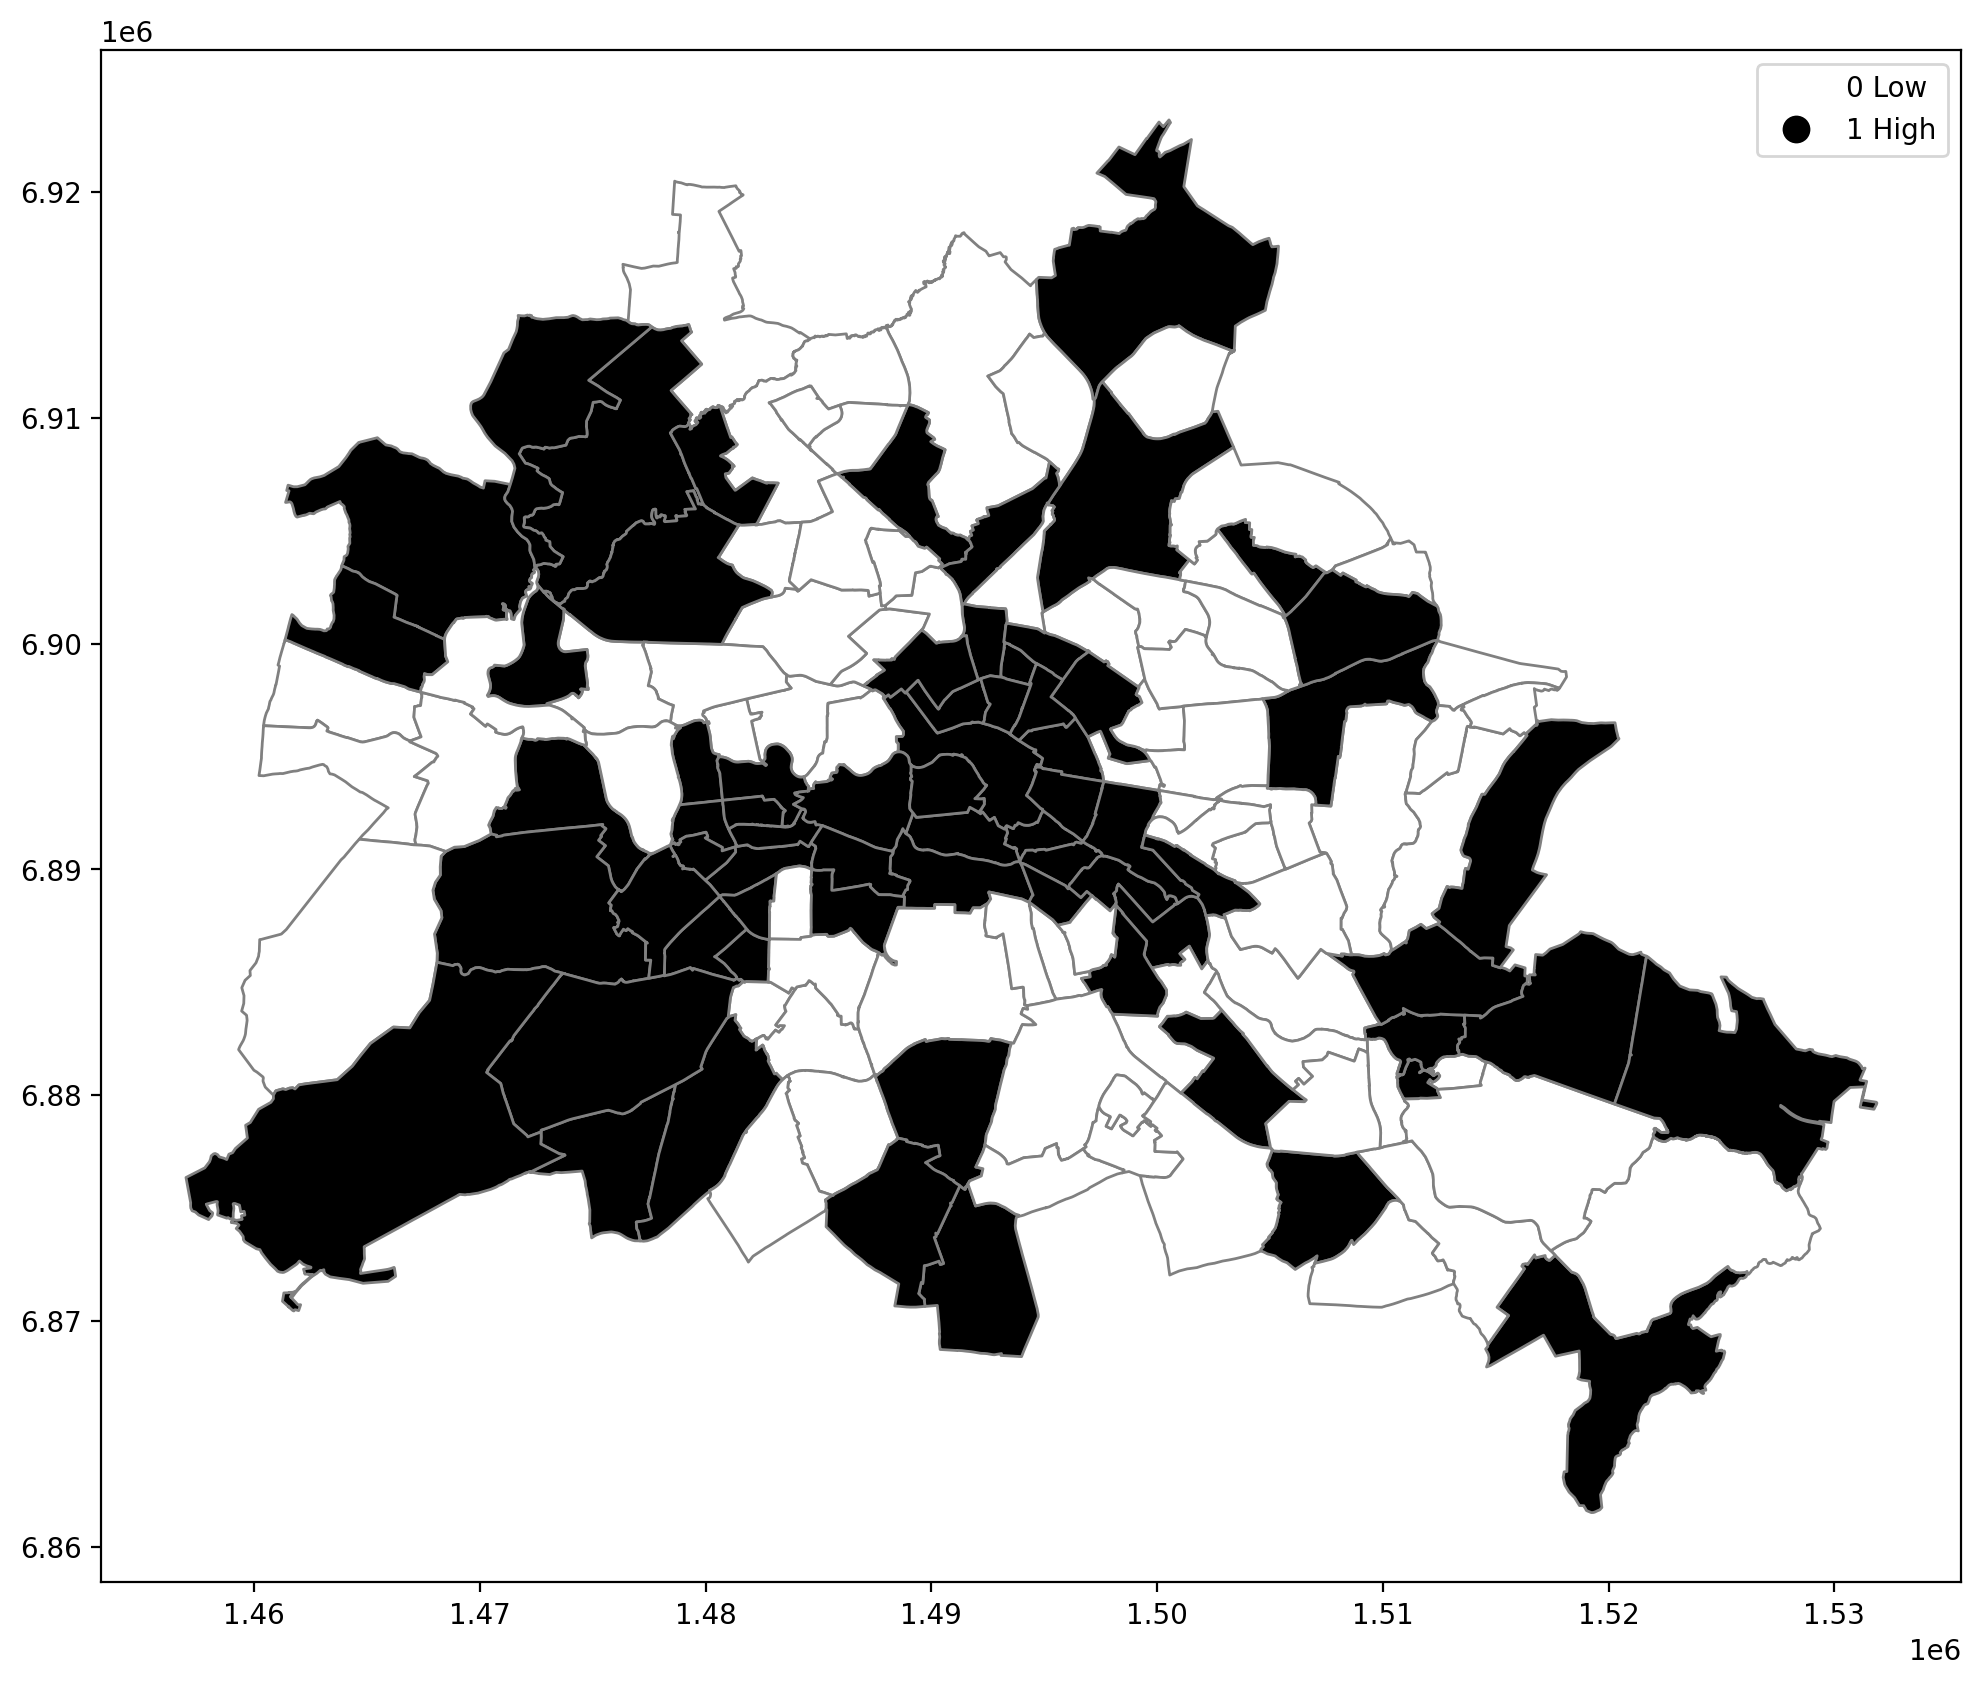

In [20]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [21]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  libpysal.weights.Queen.from_dataframe(df, use_index=True)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [22]:
jc.bb

np.float64(121.0)

In [23]:
jc.ww

np.float64(114.0)

In [24]:
jc.bw

np.float64(150.0)

Note that the three cases exhaust all possibilities:

In [25]:
jc.bb + jc.ww + jc.bw

np.float64(385.0)

and

In [26]:
wq.s0 / 2

np.float64(385.0)

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 121 BB joins:

In [27]:
jc.bb

np.float64(121.0)

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [28]:
jc.mean_bb

np.float64(92.65365365365365)

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [29]:
jc.p_sim_bb


np.float64(0.001)

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [30]:
wq.transform = 'r'

In [31]:
y = df['median_pri']

Moran's I is a test for global autocorrelation for a continuous attribute:

In [32]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

np.float64(0.09715984916381674)

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

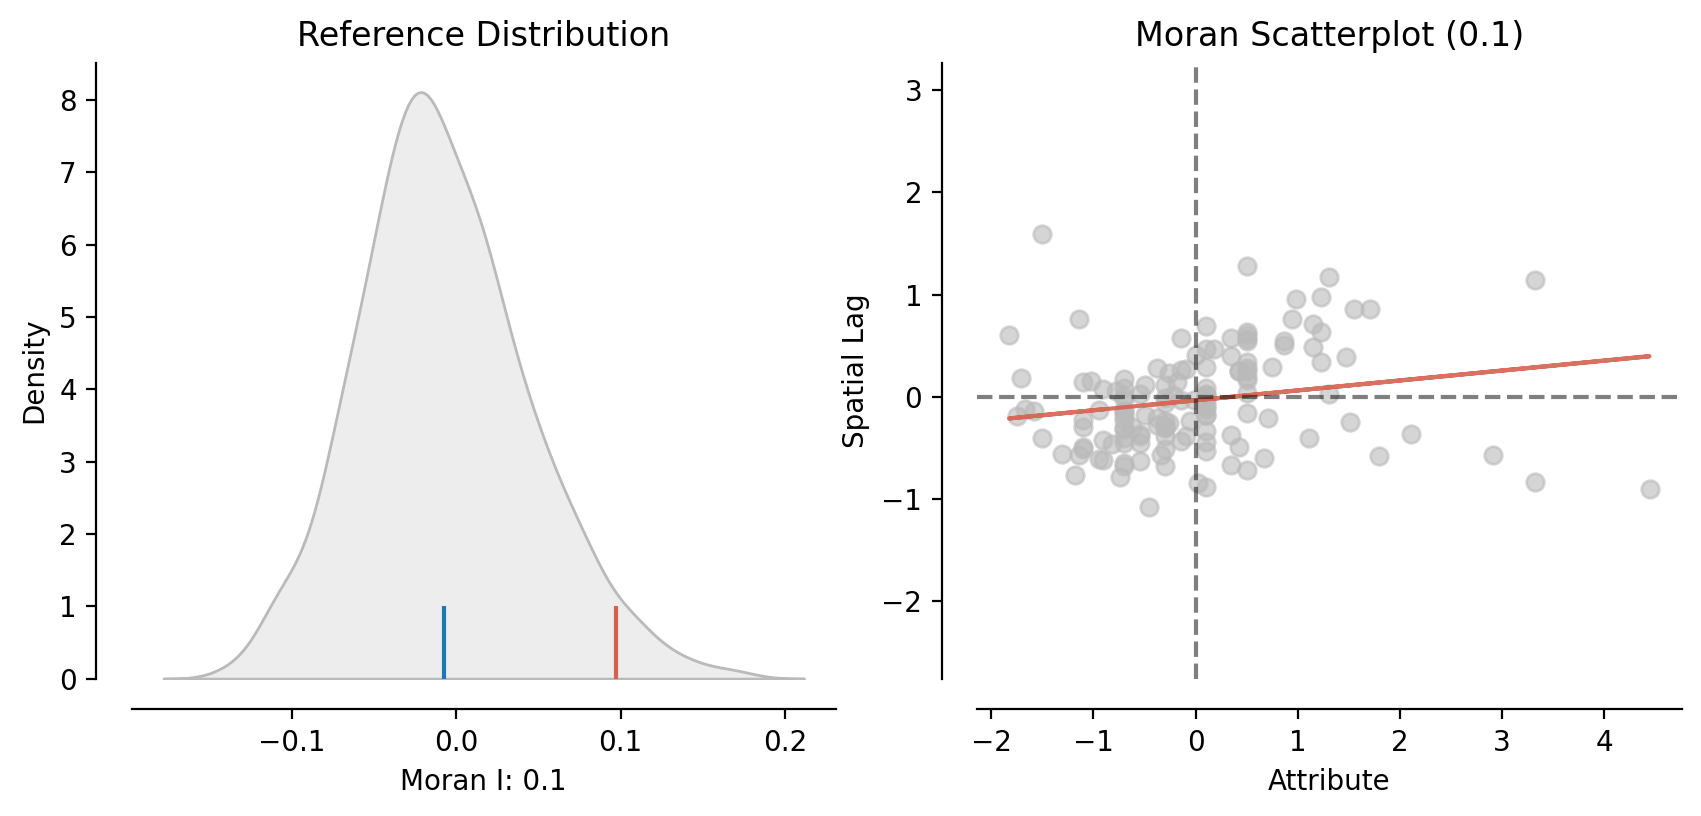

In [33]:
mi = esda.moran.Moran(y, wq)

plot_moran(mi, zstandard=True)
plt.show()

Here our observed value is again in the upper tail, although visually it does
not look as extreme relative to the binary case. Yet, it is still statistically significant:

In [34]:
mi.p_sim

np.float64(0.034)

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
d

In [35]:
np.random.seed(12345)

In [36]:
wq.transform = 'r'
lag_price = libpysal.weights.lag_spatial(wq, df['median_pri'])

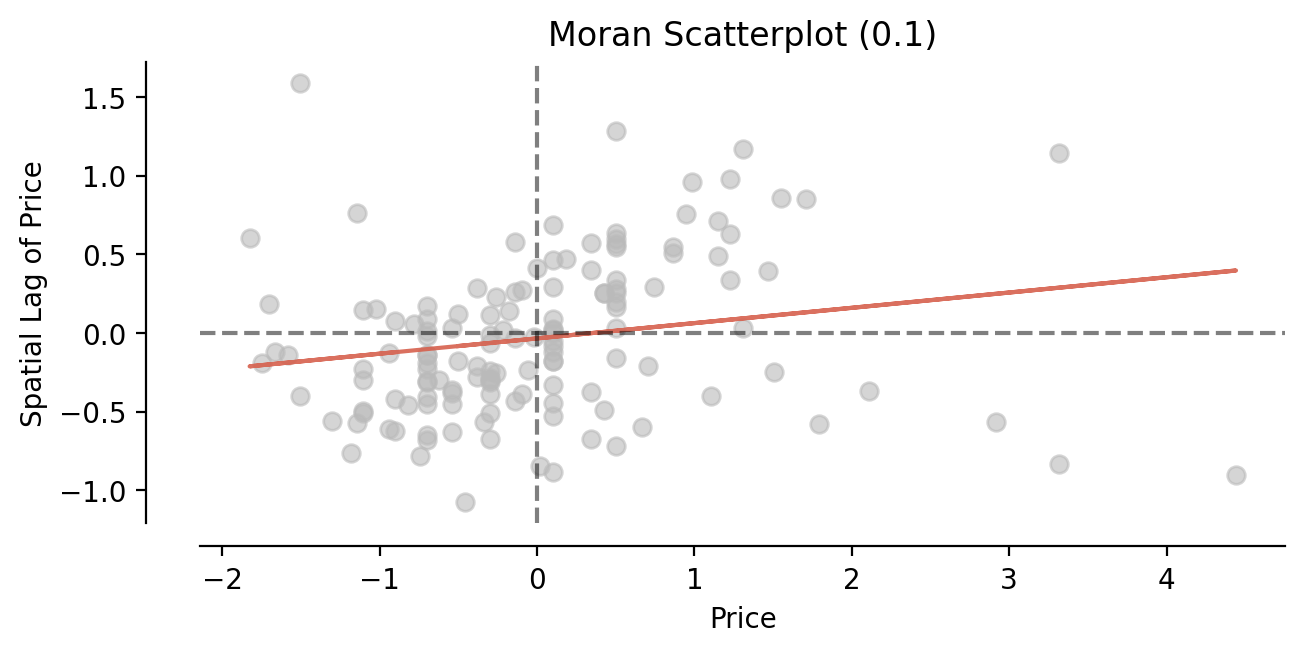

In [37]:
from splot.esda import moran_scatterplot

# Ensure Moran object 'mi' exists
try:
    mi
except NameError:
    try:
        import esda
    except Exception as e:
        raise ImportError("Missing required package 'esda'. Install with `pip install esda` or `pip install pysal` and restart the kernel.") from e
    if 'y' not in globals() or 'wq' not in globals():
        raise NameError("Variables 'y' and 'wq' are required to compute Moran's I. Run the earlier cells that build the weights ('wq') and set 'y' (e.g., df['median_pri']).")
    mi = esda.moran.Moran(y, wq)

fig, ax = moran_scatterplot(mi, aspect_equal=True)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.show()

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [38]:
li = esda.moran.Moran_Local(y, wq)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [39]:
li.q

array([2, 1, 1, 4, 2, 3, 2, 1, 3, 4, 3, 1, 3, 1, 1, 3, 3, 2, 3, 1, 1, 1,
       1, 2, 2, 3, 4, 4, 3, 4, 2, 3, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       2, 3, 3, 2, 2, 4, 3, 3, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 2, 2,
       2, 4, 4, 3, 3, 4, 3, 4, 2, 4, 4, 1, 2, 1, 4, 3, 4, 2, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 3, 4, 1, 1, 1, 3, 3, 1, 1, 1, 3, 4, 1, 4, 2, 3, 1,
       1, 2, 4, 2, 2, 2, 1, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3])

In [40]:
li.p_sim

array([0.353, 0.078, 0.308, 0.096, 0.006, 0.392, 0.324, 0.436, 0.488,
       0.233, 0.371, 0.123, 0.048, 0.005, 0.065, 0.156, 0.2  , 0.12 ,
       0.029, 0.005, 0.22 , 0.233, 0.136, 0.25 , 0.128, 0.261, 0.062,
       0.07 , 0.334, 0.343, 0.32 , 0.047, 0.178, 0.221, 0.217, 0.441,
       0.012, 0.054, 0.346, 0.458, 0.047, 0.093, 0.057, 0.241, 0.236,
       0.201, 0.134, 0.001, 0.266, 0.492, 0.233, 0.336, 0.406, 0.403,
       0.063, 0.296, 0.238, 0.087, 0.206, 0.476, 0.487, 0.292, 0.089,
       0.03 , 0.333, 0.113, 0.441, 0.065, 0.036, 0.462, 0.261, 0.04 ,
       0.495, 0.412, 0.474, 0.165, 0.407, 0.212, 0.315, 0.093, 0.167,
       0.289, 0.013, 0.412, 0.442, 0.079, 0.151, 0.258, 0.268, 0.135,
       0.276, 0.49 , 0.196, 0.313, 0.346, 0.187, 0.127, 0.066, 0.063,
       0.211, 0.064, 0.13 , 0.133, 0.197, 0.326, 0.448, 0.044, 0.345,
       0.273, 0.008, 0.026, 0.217, 0.221, 0.373, 0.44 , 0.329, 0.077,
       0.384, 0.208, 0.261, 0.453, 0.394, 0.04 , 0.253, 0.048, 0.017,
       0.034, 0.328,

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [41]:
(li.p_sim < 0.05).sum()

np.int64(22)

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [42]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [43]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


(<Figure size 640x480 with 1 Axes>, <Axes: >)

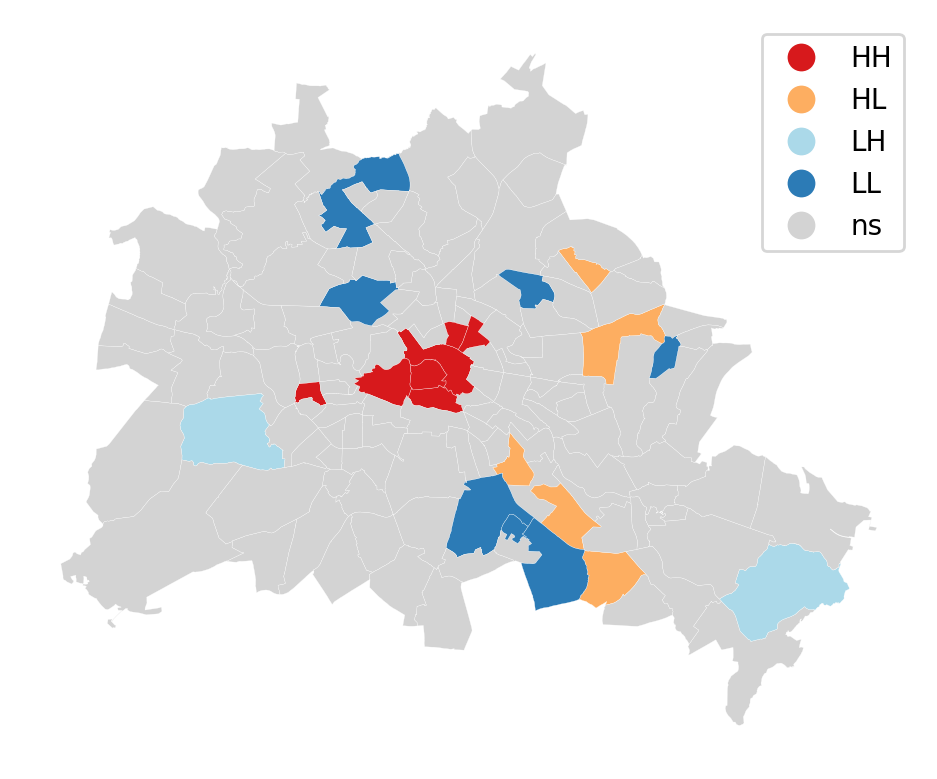

In [44]:
from esda import Moran_Local

li = Moran_Local(y, wq)

lisa_cluster(li, df, p=0.05)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

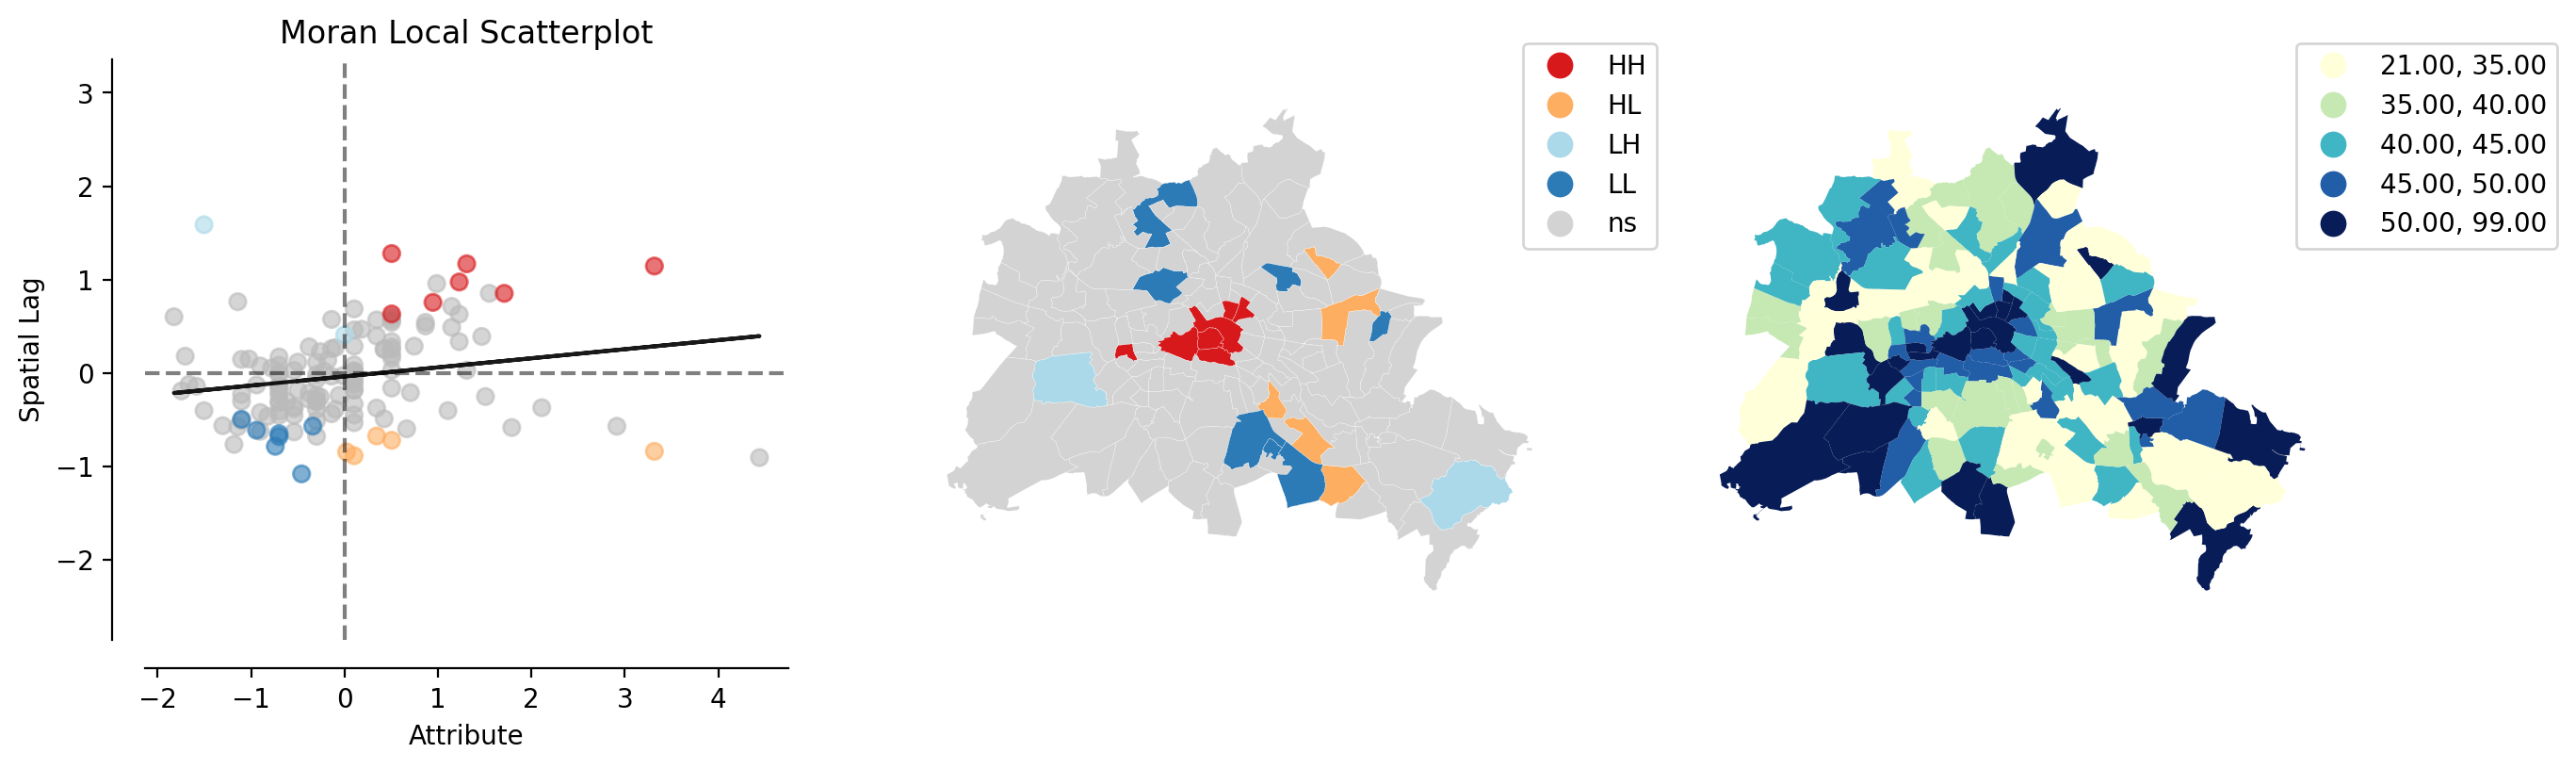

In [45]:
plot_local_autocorrelation(li, df, attribute='median_pri')
